# Class6: 循环神经网络
## Prerequisites
- Setup virtul environment
- `python3.6.9` + `TensorFlow2.3.0` + `sklearn` + `pandas` + `matplotlib`

## 6.0 回顾
- **卷积神经网络:**
  - 卷积
    - 特征提取器, CBAPD
  - 卷积神经网络
    - 借助**卷积核**提取**空间特征**后，送入全连接网络, 实现离散数据的分类

## 6.1 循环核
- 具有记忆力
- **不同时刻的参数**共享, 实现了对时间序列的信息提取
- $$输入指定维度的x_t\ 输出指定维度的y_t\ $$
- $$n个记忆体内存储的状态信息h_t\  + 下面待训练参数矩阵 w_{xh}\  + 周围侧面待训练参数矩阵 w_{hh}\ + 上面待训练参数矩阵w_{hy}\ $$
  - 前向传播时: $$h_t\ 在每个时刻都被刷新，w_{xh}\ w_{hh}\ w_{hy}\ 自始至终都固定不变$$
  - 反向传播时: $$x_h\ w_{hh}\ w_{hy}\ 被梯度下降法更新$$
  - $$h_t = 激活函数tanh(x_tw_{xh} + h_{t-1}w_{hh} + bh)\ $$
  - $$y_t = 激活函数softmax(h_tw_{hy}+by)\ 是循环网络末层, 是一层全连接$$

## 6.2 循环核时间步展开
- 将循环核按时间步展开, 按照时间轴方向展开t步: $$x_0\ \ x_1\ \ x_2\ \ ... x_{t-1} \ \ x_t\ $$
- $$每个时刻h_t 被刷新,记忆体周围的参数矩阵w_{xh}  + w_{hh} + w_{hy} 固定不变(类似于人脑中的记忆体, 每个时刻会根据当前的输入而更新, 当前时刻的推理是根据以往的知识积累, 用固化下来的参数矩阵进行推理判断), 进行训练优化, 得到最好的参数矩阵, 进行前向传播, 输出连续数据的预测结果\$$

## 6.3 循环计算层
- **每个**循环核构成一**层**循环计算层
  - 每个循环核中**记忆体的个数**, 可以根据需求**任意指定**
- 层数是向输出方向增长的

## 6.4 TF描述循环计算层
```
tf.keras.layers.SimpleRNN(记忆体个数，activation=‘激活函数’, 
return_sequences=是否每个时刻输出ht到下一层)
activation=‘激活函数’ (不写，默认使用tanh) 
return_sequences=True 循环核各时刻会把ht推送到到下一层
return_sequences=False 循环核仅在最后一个时刻把ht推送到到下一层(默认)

例:SimpleRNN(3, return_sequences=True)
```
- 送入RNN时， 要求x_train维度是3维:
  - [送入样本个数, 循环核时间展开步的步数, 每个时间步输入特征个数]

## 6.5 循环计算过程I
- 字母预测
  - 目标: 输入a预测出b，输入b预测出c， 输入c预测出d，输入d预测出e，输入e预测出a
  - 将a b c d e用数字表示出来: 独热码进行编码
    - a: 10000
    - b: 01000
    - c: 00100
    - d: 00010
    - e: 00001
  - $$随机生成w_{xh}  \ \ w_{hh} \ \ w_{hy} 三参数的矩阵值$$
  - 记忆体个数设为: $$3$$
  - 上一时刻, 起始时刻的记忆体信息: $$ h_{t-1}=0$$
  - $$代入随机生成的三参数数值和初始h_{t-1}值,计算当前时刻的h_t = tanh(x_tw_{xh} + h_{t-1}w_{hh} + bh), 将记忆体存储的状态信息进行更新$$
  - $$将得到的h_t矩阵值代入公式softmax(h_tw_{hy}+by) \\ 预测出y_t结果, 概率最大的即为结果\$$

## 6.6 字母预测onehot_1pre1
- RNN实现连续输入1个字母预测下一个字母
- 字母进行独热码编码one hot


Epoch 1/100
1/1 [==============================] - 0s 38ms/step - loss: 1.8083 - sparse_categorical_accuracy: 0.2000
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 1.7858 - sparse_categorical_accuracy: 0.2000
Epoch 3/100
1/1 [==============================] - 0s 14ms/step - loss: 1.7636 - sparse_categorical_accuracy: 0.2000
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 1.7418 - sparse_categorical_accuracy: 0.2000
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 1.7204 - sparse_categorical_accuracy: 0.2000
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 1.6993 - sparse_categorical_accuracy: 0.2000
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 1.6786 - sparse_categorical_accuracy: 0.2000
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 1.6582 - sparse_categorical_accuracy: 0.2000
Epoch 9/100
1/1 [==============================] - 0s 14ms/step 

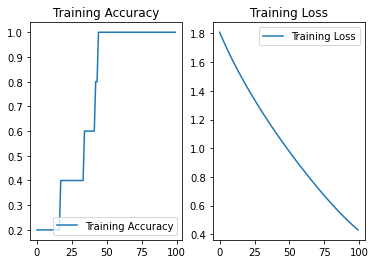

input the number of test alphabet:5
input test alphabet:a
Consider rewriting this model with the Functional API.
a->b
input test alphabet:b
b->c
input test alphabet:c
c->d
input test alphabet:d
d->e
input test alphabet:e
e->a


In [ ]:
# p15_rnn_onehot_1pre1.py

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import os

input_word = "abcde"
w_to_id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}  # 单词映射到数值id的词典
id_to_onehot = {0: [1., 0., 0., 0., 0.], 1: [0., 1., 0., 0., 0.], 2: [0., 0., 1., 0., 0.], 3: [0., 0., 0., 1., 0.],
                4: [0., 0., 0., 0., 1.]}  # id编码为one-hot

# ------------------------- 构建输入特征/标签对 -----------------------------------
x_train = [id_to_onehot[w_to_id['a']], id_to_onehot[w_to_id['b']], id_to_onehot[w_to_id['c']],
           id_to_onehot[w_to_id['d']], id_to_onehot[w_to_id['e']]]
y_train = [w_to_id['b'], w_to_id['c'], w_to_id['d'], w_to_id['e'], w_to_id['a']]
# ------------------------- 构建输入特征/标签对 -----------------------------------


np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 使x_train符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为len(x_train)；输入1个字母出结果，循环核时间展开步数为1; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
x_train = np.reshape(x_train, (len(x_train), 1, 5))
y_train = np.array(y_train)

model = tf.keras.Sequential([
    SimpleRNN(3),
    Dense(5, activation='softmax')    # 全连接网络, 输出映射到独热码编码,找到输出概率最大的5个字母中的一个
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/rnn_onehot_1pre1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

############### 应用训练好的模型进行predict #############

preNum = int(input("input the number of test alphabet:"))
for i in range(preNum):
    alphabet1 = input("input test alphabet:")
    alphabet = [id_to_onehot[w_to_id[alphabet1]]]
    # 使alphabet符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。此处验证效果送入了1个样本，送入样本数为1；输入1个字母出结果，所以循环核时间展开步数为1; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
    alphabet = np.reshape(alphabet, (1, 1, 5))
    result = model.predict([alphabet])
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])


## 6.7 循环计算过程II
- 连续输入4个(多个)字母, 预测下一个字母
- 使用3个记忆体, 初始时刻为[0 0 0], 每个时间步之后被计算依次更新 
- 每个时间步具有相同的$$w_{xh}  \ \ w_{hh} \ \ bh $$




## 6.8 字母预测onehot_4pre1
- RNN实现连续输入4个字母预测下一个字母
  - 输入abcd输出e 
  - 输入bcde输出a 
  - 输入cdea输出b 
  - 输入deab输出c 
  - 输入eabc输出d
- 字母进行独热码编码one hot

### 6.8.1 交互式输出字母预测结果

-------------load the model-----------------
Epoch 1/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0281 - sparse_categorical_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0280 - sparse_categorical_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0279 - sparse_categorical_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0278 - sparse_categorical_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0276 - sparse_categorical_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0275 - sparse_categorical_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0274 - sparse_categorical_accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0273 - sparse_categorical_accuracy: 1.0000
Epoch 9/100
1/1 [==

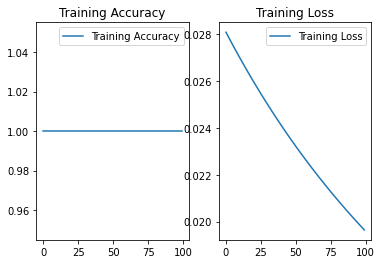

input the number of test alphabet:5
input test alphabet:abcd
Consider rewriting this model with the Functional API.
abcd->e
input test alphabet:bcde
bcde->a
input test alphabet:cdea
cdea->b
input test alphabet:deab
deab->c
input test alphabet:eabc
eabc->d


In [ ]:
# p21_rnn_onehot_4pre1.py

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import os

input_word = "abcde"
w_to_id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}  # 单词映射到数值id的词典
id_to_onehot = {0: [1., 0., 0., 0., 0.], 1: [0., 1., 0., 0., 0.], 2: [0., 0., 1., 0., 0.], 3: [0., 0., 0., 1., 0.],
                4: [0., 0., 0., 0., 1.]}  # id编码为one-hot
# ------------------------- 构建输入特征/标签对 -----------------------------------
x_train = [
    [id_to_onehot[w_to_id['a']], id_to_onehot[w_to_id['b']], id_to_onehot[w_to_id['c']], id_to_onehot[w_to_id['d']]],
    [id_to_onehot[w_to_id['b']], id_to_onehot[w_to_id['c']], id_to_onehot[w_to_id['d']], id_to_onehot[w_to_id['e']]],
    [id_to_onehot[w_to_id['c']], id_to_onehot[w_to_id['d']], id_to_onehot[w_to_id['e']], id_to_onehot[w_to_id['a']]],
    [id_to_onehot[w_to_id['d']], id_to_onehot[w_to_id['e']], id_to_onehot[w_to_id['a']], id_to_onehot[w_to_id['b']]],
    [id_to_onehot[w_to_id['e']], id_to_onehot[w_to_id['a']], id_to_onehot[w_to_id['b']], id_to_onehot[w_to_id['c']]],
]
y_train = [w_to_id['e'], w_to_id['a'], w_to_id['b'], w_to_id['c'], w_to_id['d']]
# ------------------------- 构建输入特征/标签对 -----------------------------------


np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 使x_train符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为len(x_train)；输入4个字母出结果，循环核时间展开步数为4; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
x_train = np.reshape(x_train, (len(x_train), 4, 5))
y_train = np.array(y_train)

model = tf.keras.Sequential([
    SimpleRNN(3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/rnn_onehot_4pre1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

############### predict #############

preNum = int(input("input the number of test alphabet:"))
for i in range(preNum):
    alphabet1 = input("input test alphabet:")
    alphabet = [id_to_onehot[w_to_id[a]] for a in alphabet1]
    # 使alphabet符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。此处验证效果送入了1个样本，送入样本数为1；输入4个字母出结果，所以循环核时间展开步数为4; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
    alphabet = np.reshape(alphabet, (1, 4, 5))
    result = model.predict([alphabet])
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])

### 6.8.2 一次性输出字母预测结果

-------------load the model-----------------
Epoch 1/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0196 - sparse_categorical_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0195 - sparse_categorical_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0195 - sparse_categorical_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0194 - sparse_categorical_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0193 - sparse_categorical_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0193 - sparse_categorical_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0192 - sparse_categorical_accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0191 - sparse_categorical_accuracy: 1.0000
Epoch 9/100
1/1 [==

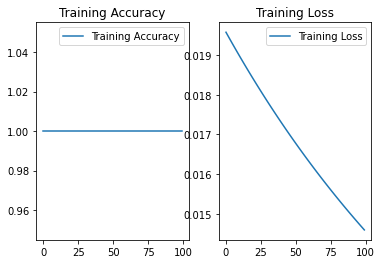

Consider rewriting this model with the Functional API.
abcd->e
bcde->a
cdea->b
deab->c
eabc->d


In [ ]:
# p21_rnn_onehot_4pre1.py
# 一次性输出predict结果
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import os

input_word = "abcde"
w_to_id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}  # 单词映射到数值id的词典
id_to_onehot = {0: [1., 0., 0., 0., 0.], 1: [0., 1., 0., 0., 0.], 2: [0., 0., 1., 0., 0.], 3: [0., 0., 0., 1., 0.],
                4: [0., 0., 0., 0., 1.]}  # id编码为one-hot
# ------------------------- 构建输入特征/标签对 -----------------------------------
x_train = [
    [id_to_onehot[w_to_id['a']], id_to_onehot[w_to_id['b']], id_to_onehot[w_to_id['c']], id_to_onehot[w_to_id['d']]],
    [id_to_onehot[w_to_id['b']], id_to_onehot[w_to_id['c']], id_to_onehot[w_to_id['d']], id_to_onehot[w_to_id['e']]],
    [id_to_onehot[w_to_id['c']], id_to_onehot[w_to_id['d']], id_to_onehot[w_to_id['e']], id_to_onehot[w_to_id['a']]],
    [id_to_onehot[w_to_id['d']], id_to_onehot[w_to_id['e']], id_to_onehot[w_to_id['a']], id_to_onehot[w_to_id['b']]],
    [id_to_onehot[w_to_id['e']], id_to_onehot[w_to_id['a']], id_to_onehot[w_to_id['b']], id_to_onehot[w_to_id['c']]],
]
y_train = [w_to_id['e'], w_to_id['a'], w_to_id['b'], w_to_id['c'], w_to_id['d']]
# ------------------------- 构建输入特征/标签对 -----------------------------------


np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 使x_train符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为len(x_train)；输入4个字母出结果，循环核时间展开步数为4; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
x_train = np.reshape(x_train, (len(x_train), 4, 5))
y_train = np.array(y_train)

model = tf.keras.Sequential([
    SimpleRNN(3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/rnn_onehot_4pre1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

###############一次性输出predict结果#############

# preNum = int(input("input the number of test alphabet:"))

alphabet_all = ["abcd", "bcde", "cdea", "deab", "eabc"]
preNum = len(alphabet_all)

for i in range(preNum):
    # alphabet1 = input("input test alphabet:")
    alphabet1 = alphabet_all[i]
    
    alphabet = [id_to_onehot[w_to_id[a]] for a in alphabet1]
    # 使alphabet符合SimpleRNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。此处验证效果送入了1个样本，送入样本数为1；输入4个字母出结果，所以循环核时间展开步数为4; 表示为独热码有5个输入特征，每个时间步输入特征个数为5
    alphabet = np.reshape(alphabet, (1, 4, 5))
    result = model.predict([alphabet])
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])

## 6.9 Embedding编码
- 前面用到的独热码位宽要与词汇量一致
- Embeddig是一种单词编码方法
- 用低维向量实现了编码
- 编码通过神经网络训练优化，能表达出单词间的相关性
- tf函数表示

  ```
  tf.keras.layers.Embedding(词汇表大小，编码维度)
```

- x_train 要求维度格式

  ```
  [送入样本数， 循环核时间展开步数]
  ```

## 6.10 字母预测Embedding_1pre1
- RNN实现连续输入1个字母预测下一个字母
- Embedding编码

### 6.10.1 交互式输出字母预测结果

Epoch 1/100
1/1 [==============================] - 0s 19ms/step - loss: 1.6253 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 1.6180 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 18ms/step - loss: 1.6113 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 1.6049 - sparse_categorical_accuracy: 0.2000
Epoch 5/100
1/1 [==============================] - 0s 18ms/step - loss: 1.5985 - sparse_categorical_accuracy: 0.2000
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 1.5919 - sparse_categorical_accuracy: 0.2000
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 1.5851 - sparse_categorical_accuracy: 0.4000
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 1.5778 - sparse_categorical_accuracy: 0.4000
Epoch 9/100
1/1 [==============================] - 0

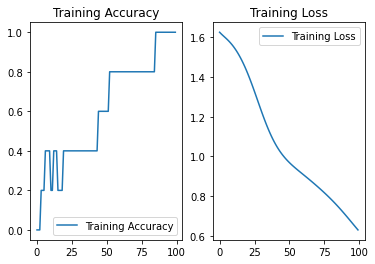

input the number of test alphabet:5
input test alphabet:a
a->b
input test alphabet:b
b->c
input test alphabet:c
c->d
input test alphabet:d
d->e
input test alphabet:e
e->a


In [ ]:
# p27_rnn_embedding_1pre1.py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
import matplotlib.pyplot as plt
import os

input_word = "abcde"
w_to_id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}  # 单词映射到数值id的词典

x_train = [w_to_id['a'], w_to_id['b'], w_to_id['c'], w_to_id['d'], w_to_id['e']]
y_train = [w_to_id['b'], w_to_id['c'], w_to_id['d'], w_to_id['e'], w_to_id['a']]

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 使x_train符合Embedding输入要求：[送入样本数， 循环核时间展开步数] ，
# 此处整个数据集送入所以送入，送入样本数为len(x_train)；输入1个字母出结果，循环核时间展开步数为1。
x_train = np.reshape(x_train, (len(x_train), 1))
y_train = np.array(y_train)

model = tf.keras.Sequential([
    Embedding(5, 2),  # Embedding层, 先对输入数据进行编码, Embedding层可以生成(5x2)的可训练参数矩阵, 实现编码可训练
    SimpleRNN(3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/run_embedding_1pre1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

############### predict #############

preNum = int(input("input the number of test alphabet:"))
for i in range(preNum):
    alphabet1 = input("input test alphabet:")
    alphabet = [w_to_id[alphabet1]]
    # 使alphabet符合Embedding输入要求：[送入样本数， 循环核时间展开步数]。
    # 此处验证效果送入了1个样本，送入样本数为1；输入1个字母出结果，循环核时间展开步数为1。
    alphabet = np.reshape(alphabet, (1, 1))
    result = model.predict(alphabet)
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])

### 6.10.2 一次性输出字母预测结果

-------------load the model-----------------
Epoch 1/100
1/1 [==============================] - 0s 18ms/step - loss: 0.6222 - sparse_categorical_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 0.6139 - sparse_categorical_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 18ms/step - loss: 0.6058 - sparse_categorical_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 0.5978 - sparse_categorical_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 18ms/step - loss: 0.5898 - sparse_categorical_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 0.5820 - sparse_categorical_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5744 - sparse_categorical_accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5668 - sparse_categorical_accuracy: 1.0000
Epoch 9/100
1/1 [==

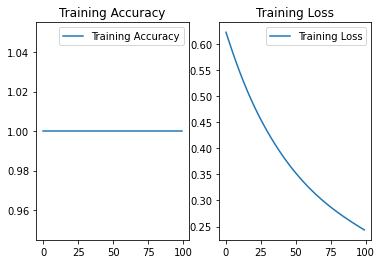

a->b
b->c
c->d
d->e
e->a


In [ ]:
# p27_rnn_embedding_1pre1.py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
import matplotlib.pyplot as plt
import os

input_word = "abcde"
w_to_id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}  # 单词映射到数值id的词典

x_train = [w_to_id['a'], w_to_id['b'], w_to_id['c'], w_to_id['d'], w_to_id['e']]
y_train = [w_to_id['b'], w_to_id['c'], w_to_id['d'], w_to_id['e'], w_to_id['a']]

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 使x_train符合Embedding输入要求：[送入样本数， 循环核时间展开步数] ，
# 此处整个数据集送入所以送入，送入样本数为len(x_train)；输入1个字母出结果，循环核时间展开步数为1。
x_train = np.reshape(x_train, (len(x_train), 1))
y_train = np.array(y_train)

model = tf.keras.Sequential([
    Embedding(5, 2),
    SimpleRNN(3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/run_embedding_1pre1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

############### predict #############

alphabet_all = ["a", "b", "c", "d", "e"]
preNum = len(alphabet_all)

for i in range(preNum):
    alphabet1 = alphabet_all[i]
    alphabet = [w_to_id[alphabet1]]
    # 使alphabet符合Embedding输入要求：[送入样本数， 循环核时间展开步数]。
    # 此处验证效果送入了1个样本，送入样本数为1；输入1个字母出结果，循环核时间展开步数为1。
    alphabet = np.reshape(alphabet, (1, 1))
    result = model.predict(alphabet)
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])

## 6.11 字母预测Embedding_4pre1
- RNN实现连续输入4个字母预测下一个字母
- Embedding编码
- 词汇量26个
- 字母a->z用数字0-25依次一一进行表示
- for loop 构建`x_train` `y_train`
  - 从数字列表中把连续4个数作为输入特征x_train
  - 第5个数作为标签y_train


### 6.11.1 交互式输出字母预测结果

-------------load the model-----------------
Epoch 1/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 9/100
1/1 [==

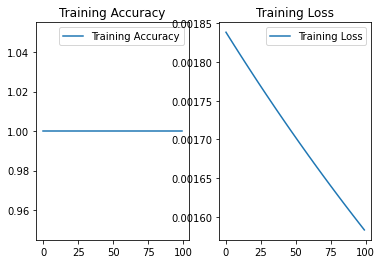

input the number of test alphabet:3
input test alphabet:abcd
abcd->e
input test alphabet:bcde
bcde->f
input test alphabet:vwxy
vwxy->z


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
import matplotlib.pyplot as plt
import os

input_word = "abcdefghijklmnopqrstuvwxyz"
w_to_id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4,
           'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9,
           'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14,
           'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19,
           'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}  # 单词映射到数值id的词典

training_set_scaled = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                       11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                       21, 22, 23, 24, 25]

x_train = []
y_train = []

for i in range(4, 26):
    x_train.append(training_set_scaled[i - 4:i])
    y_train.append(training_set_scaled[i])

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 使x_train符合Embedding输入要求：[送入样本数， 循环核时间展开步数] ，
# 此处整个数据集送入所以送入，送入样本数为len(x_train)；输入4个字母出结果，循环核时间展开步数为4。
x_train = np.reshape(x_train, (len(x_train), 4))
y_train = np.array(y_train)

model = tf.keras.Sequential([
    Embedding(26, 2),
    SimpleRNN(10),
    Dense(26, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/rnn_embedding_4pre1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

################# predict ##################

preNum = int(input("input the number of test alphabet:"))
for i in range(preNum):
    alphabet1 = input("input test alphabet:")
    alphabet = [w_to_id[a] for a in alphabet1]
    # 使alphabet符合Embedding输入要求：[送入样本数， 时间展开步数]。
    # 此处验证效果送入了1个样本，送入样本数为1；输入4个字母出结果，循环核时间展开步数为4。
    alphabet = np.reshape(alphabet, (1, 4))
    result = model.predict([alphabet])
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])

### 6.11.2 一次性输出字母预测结果



Epoch 1/100
1/1 [==============================] - 0s 16ms/step - loss: 3.2579 - sparse_categorical_accuracy: 0.0455
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 3.2364 - sparse_categorical_accuracy: 0.0455
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 3.2139 - sparse_categorical_accuracy: 0.0909
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 3.1891 - sparse_categorical_accuracy: 0.0455
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 3.1619 - sparse_categorical_accuracy: 0.0455
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 3.1318 - sparse_categorical_accuracy: 0.0455
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 3.0974 - sparse_categorical_accuracy: 0.0455
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 3.0570 - sparse_categorical_accuracy: 0.0909
Epoch 9/100
1/1 [==============================] - 0s 18ms/step 

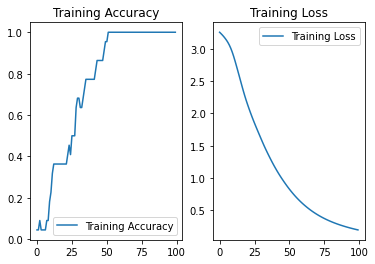

abcd->e
bcde->f
cdef->g
defg->h
efgh->i
fghi->j
ghij->k
hijk->l
ijkl->m
jklm->n
klmn->o
lmno->p
mnop->q
nopq->r
opqr->s
pqrs->t
qrst->u
rstu->v
stuv->w
tuvw->x
uvwx->y
vwxy->z


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
import matplotlib.pyplot as plt
import os

input_word = "abcdefghijklmnopqrstuvwxyz"
w_to_id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4,
           'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9,
           'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14,
           'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19,
           'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}  # 单词映射到数值id的词典

training_set_scaled = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                       11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                       21, 22, 23, 24, 25]

x_train = []
y_train = []

for i in range(4, 26):
    x_train.append(training_set_scaled[i - 4:i])
    y_train.append(training_set_scaled[i])

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 使x_train符合Embedding输入要求：[送入样本数， 循环核时间展开步数] ，
# 此处整个数据集送入所以送入，送入样本数为len(x_train)；输入4个字母出结果，循环核时间展开步数为4。
x_train = np.reshape(x_train, (len(x_train), 4))
y_train = np.array(y_train)

model = tf.keras.Sequential([
    Embedding(26, 2),
    SimpleRNN(10),
    Dense(26, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/rnn_embedding_4pre1.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

################# predict ##################

id_to_w = {v: k for k, v in w_to_id.items()}

alphabet_all = []

for i in range(4, 26):
    alphabet_all.append("".join([id_to_w[x] for x in training_set_scaled[i - 4:i]]))
    
# print(alphabet_all)
# ['abcd', 'bcde',,,'vwxy']

preNum = len(alphabet_all)

for i in range(preNum):
    alphabet1 = alphabet_all[i]
    alphabet = [w_to_id[a] for a in alphabet1]
    # 使alphabet符合Embedding输入要求：[送入样本数， 时间展开步数]。
    # 此处验证效果送入了1个样本，送入样本数为1；输入4个字母出结果，循环核时间展开步数为4。
    alphabet = np.reshape(alphabet, (1, 4))
    result = model.predict([alphabet])
    pred = tf.argmax(result, axis=1)
    pred = int(pred)
    tf.print(alphabet1 + '->' + input_word[pred])

## 6.12 RNN实现股票预测
- 数据源SH600519.csv
- 数据下载源码p37_tushare.py
  ```
  import tushare as ts
  import matplotlib.pyplot as plt

  df1 = ts.get_k_data('600519', ktype='D', start='2010-04-26', end='2020-04-26')

  datapath1 = "./SH600519.csv"
  df1.to_csv(datapath1)
  ```


In [ ]:
!pip install tushare

     |████████████████████████████████| 215kB 5.5MB/s 
     |████████████████████████████████| 204kB 7.3MB/s 
     |████████████████████████████████| 133kB 7.8MB/s 


In [ ]:
import tushare as ts
import matplotlib.pyplot as plt

df1 = ts.get_k_data('600519', ktype='D', start='2010-04-26', end='2020-04-26')

datapath1 = "./SH600519.csv"
df1.to_csv(datapath1)

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


-------------load the model-----------------
Epoch 1/50
33/33 [==============================] - 1s 36ms/step - loss: 4.9030e-04 - val_loss: 0.0014
Epoch 2/50
33/33 [==============================] - 1s 32ms/step - loss: 5.0436e-04 - val_loss: 0.0064
Epoch 3/50
33/33 [==============================] - 1s 31ms/step - loss: 4.9685e-04 - val_loss: 0.0032
Epoch 4/50
33/33 [==============================] - 1s 32ms/step - loss: 5.0310e-04 - val_loss: 0.0031
Epoch 5/50
33/33 [==============================] - 1s 32ms/step - loss: 4.5846e-04 - val_loss: 0.0030
Epoch 6/50
33/33 [==============================] - 1s 32ms/step - loss: 5.3150e-04 - val_loss: 8.7354e-04
Epoch 7/50
33/33 [==============================] - 1s 33ms/step - loss: 4.7113e-04 - val_loss: 9.2232e-04
Epoch 8/50
33/33 [==============================] - 1s 32ms/step - loss: 4.6723e-04 - val_loss: 0.0084
Epoch 9/50
33/33 [==============================] - 1s 33ms/step - loss: 5.5006e-04 - val_loss: 0.0042
Epoch 10/50
33/33 [=

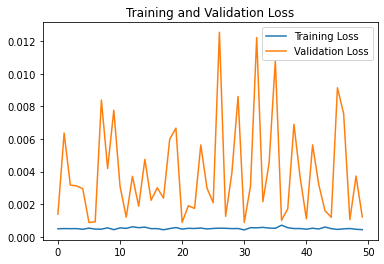

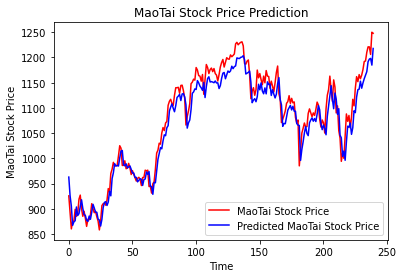

均方误差: 610.777433
均方根误差: 24.713912
平均绝对误差: 20.236795


In [ ]:
# p38_rnn_stock.py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('./SH600519.csv')  # 读取股票文件

training_set = maotai.iloc[0:2426 - 300, 2:3].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426 - 300:, 2:3].values  # 后300天的开盘价作为测试集

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []


#----------------------生成train test数据集---------------------------------------
# 测试集：csv表格中前2426-300=2126天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。

for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))
#----------------------生成train test数据集---------------------------------------


#-----------------------Sequential网络结构---------------------------------------
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),   #第一层循环计算层,记忆体设为80个,每个时间步推送ht
    Dropout(0.2),
    SimpleRNN(100),     #第二层循环计算层,记忆体设为100个
    Dropout(0.2),
    Dense(1)    # 输出值只有1个: 为第61天的开盘价
])
#-----------------------Sequential网络结构---------------------------------------


model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/rnn_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方) 
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

## 6.00 半讲小结
- 上述传统循环网络RNN
  - 通过记忆体实现短期记忆, 来进行连续数据的预测 
  - 若连续数据序列变长时, 会使**展开时间步**过长, 在反向传播更新参数时,梯度要按照**时间步连续相乘**而导致梯度消失

## 6.13 LSTM实现股票预测(LSTM计算过程_TF描述LSTM层)
- 于1997年提出，通过门控单元改善了RNN长期依赖问题
- 长短记忆网络LONG SHORT-TERM MEMORY
- **3门限**
  - 输入门(门限)
  - 遗忘门(门限)
  - 输出门(门限)
  - $$当前时刻输入特征x_t,\\上一时刻的短期记忆函数h_{t-1},\\输入门 i_t, 遗忘门f_t, 输出门o_t三门中各自待训练参数矩阵W_i, W_f, w_o, \\与相应的待训练偏置项b_i,b_f,b_o,\\ 各自经过sigmoid函数$$
  - 门限范围0-1
- **细胞态**,由过去的长期记忆+现在的候选态构成
  - $$表示长期记忆c_t$$
  - 上一时刻的长期记忆(过去的长期记忆) x 遗忘门 + 当前时刻归纳出的新知识(候选态) x 输入门
- **记忆体**的输出, 是长期记忆的一部分
  - $$表示短期记忆h_t$$
  - 细胞态经过tanh激活函数后(留存在脑中的长期记忆) x 输出门
- **候选态**
  - 等待存入长期记忆, 归纳出的新知识
- TF描述LSTM层
```
tf.keras.layers.LSTM(记忆体个数，return_sequences=是否返回输出)
return_sequences=True 各时间步输出ht,多用于中间层网络
return_sequences=False 仅最后时间步输出ht(默认), 多用于最后一层网络
```



Epoch 1/50
33/33 [==============================] - 5s 157ms/step - loss: 0.0135 - val_loss: 0.0493
Epoch 2/50
33/33 [==============================] - 4s 136ms/step - loss: 0.0013 - val_loss: 0.0140
Epoch 3/50
33/33 [==============================] - 4s 130ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 4/50
33/33 [==============================] - 4s 134ms/step - loss: 0.0013 - val_loss: 0.0204
Epoch 5/50
33/33 [==============================] - 4s 133ms/step - loss: 0.0011 - val_loss: 0.0066
Epoch 6/50
33/33 [==============================] - 4s 135ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 7/50
33/33 [==============================] - 4s 131ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 8/50
33/33 [==============================] - 4s 131ms/step - loss: 0.0010 - val_loss: 0.0129
Epoch 9/50
33/33 [==============================] - 4s 130ms/step - loss: 0.0010 - val_loss: 0.0157
Epoch 10/50
33/33 [==============================] - 4s 132ms/step - loss: 0.0010 - val_loss: 0.0161

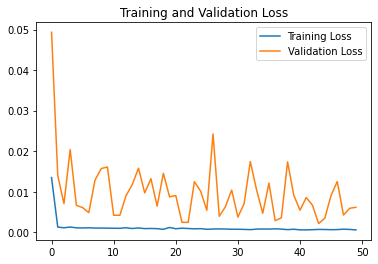

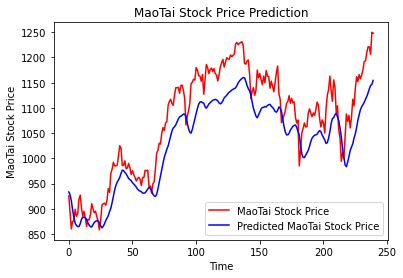

均方误差: 3084.902900
均方根误差: 55.541902
平均绝对误差: 49.045517


In [ ]:
# p47_LSTM_stock.py

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('./SH600519.csv')  # 读取股票文件

training_set = maotai.iloc[0:2426 - 300, 2:3].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426 - 300:, 2:3].values  # 后300天的开盘价作为测试集

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前2426-300=2126天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

model = tf.keras.Sequential([
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/LSTM_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

## 6.14 GRU实现股票预测(GRU计算过程_TF描述GRU层)
- GRU网络于2014年提出，优化LSTM结构
- 两门
  - $$更新门z_t$$
  - $$重置门r_t$$
  - 门限范围0-1
- $$ 记忆体h_t融合了长期记忆和短期记忆$$
- $$ 上一时刻记忆体 * (1-更新门) + 候选隐藏层 * 更新门$$
- $$候选隐藏层取决于上一时刻记忆体 * 重置门以及当前输入特征x_t$$

- TF描述GRU层
```
tf.keras.layers.GRU(记忆体个数，return_sequences=是否返回输出) return_sequences=True 各时间步输出ht
return_sequences=False 仅最后时间步输出ht(默认)
```

Epoch 1/50
33/33 [==============================] - 4s 126ms/step - loss: 0.0197 - val_loss: 0.0133
Epoch 2/50
33/33 [==============================] - 4s 117ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 3/50
33/33 [==============================] - 4s 118ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 4/50
33/33 [==============================] - 4s 117ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 5/50
33/33 [==============================] - 4s 119ms/step - loss: 9.6166e-04 - val_loss: 0.0016
Epoch 6/50
33/33 [==============================] - 4s 117ms/step - loss: 8.5176e-04 - val_loss: 0.0023
Epoch 7/50
33/33 [==============================] - 4s 118ms/step - loss: 9.0408e-04 - val_loss: 0.0015
Epoch 8/50
33/33 [==============================] - 4s 119ms/step - loss: 9.2791e-04 - val_loss: 0.0034
Epoch 9/50
33/33 [==============================] - 4s 119ms/step - loss: 9.8747e-04 - val_loss: 0.0020
Epoch 10/50
33/33 [==============================] - 4s 116ms/step - loss: 8.724

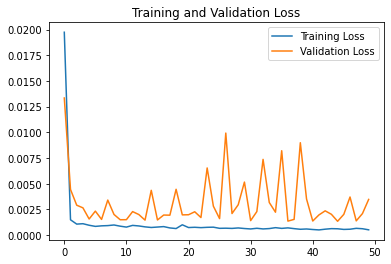

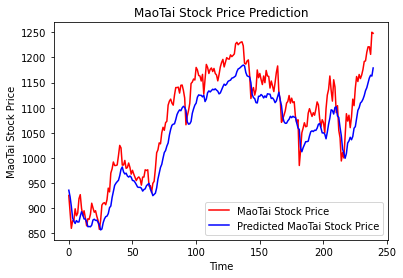

均方误差: 1743.490399
均方根误差: 41.755124
平均绝对误差: 36.362533


In [ ]:
# p56_GRU_stock.py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('./SH600519.csv')  # 读取股票文件

training_set = maotai.iloc[0:2426 - 300, 2:3].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426 - 300:, 2:3].values  # 后300天的开盘价作为测试集

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前2426-300=2126天数据
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))
# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建300-60=240组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

model = tf.keras.Sequential([
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

checkpoint_save_path = "./checkpoint/stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

################## predict ######################
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)